# 日々の軌道高度データを作成する

毎日0:00UT時点での軌道要素データ(軌道長半径・近点・遠点)を線形補間で作成する。0:00UT時点での実際の衛星の位置ではない。

複数の EPOCH の時間間隔が1秒以下の時には、CREATION_DATE が新しいもの1つを残して、他は削除してから、補間を行う。
(必ずしも最後のEPOCHが残るわけではない)

In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", 80)

In [3]:
# 対象とする衛星番号 (Hinode)
norad_cat_id = 29479

In [4]:
# 対象期間
date_start = datetime(2011, 1, 1, 0, 0)
date_end   = datetime(2017, 1, 1, 0, 0)

In [5]:
# 各columnの型
# https://www.space-track.org/basicspacedata/modeldef/class/gp/format/html も参照のこと
# decimal型のcolumnはfloat64として取り扱うことにする
dtype = {'CCSDS_OMM_VERS': str,  'COMMENT': str,  'CREATION_DATE': 'datetime64[ns]',  'ORIGINATOR': str, 
       'OBJECT_NAME': str,  'OBJECT_ID': str,  'CENTER_NAME': str,  'REF_FRAME': str, 
       'TIME_SYSTEM': str,  'MEAN_ELEMENT_THEORY': str,  'EPOCH': 'datetime64[ns]',  'MEAN_MOTION': 'float64', 
       'ECCENTRICITY': 'float64',  'INCLINATION': 'float64',  'RA_OF_ASC_NODE': 'float64', 
       'ARG_OF_PERICENTER': 'float64',  'MEAN_ANOMALY': 'float64',  'EPHEMERIS_TYPE': 'int8', 
       'CLASSIFICATION_TYPE': str,  'NORAD_CAT_ID': 'uint32',  'ELEMENT_SET_NO': 'uint16', 
       'REV_AT_EPOCH': 'uint32',  'BSTAR': 'float64',  'MEAN_MOTION_DOT': 'float64',  'MEAN_MOTION_DDOT': 'float64', 
       'SEMIMAJOR_AXIS': 'float64',  'PERIOD': 'float64',  'APOAPSIS': 'float64',  'PERIAPSIS': 'float64',  'OBJECT_TYPE': str, 
       'RCS_SIZE': str,  'COUNTRY_CODE': str,  'LAUNCH_DATE': 'datetime64[ns]',  'SITE': str,  'DECAY_DATE': 'datetime64[ns]', 
       'FILE': 'uint64',  'GP_ID': 'uint32',  'TLE_LINE0': str,  'TLE_LINE1': str,  'TLE_LINE2': str}

# 以下のcolumnは日時として解釈する (元データが空欄の場合は NaT になる)
convert_dates = ['EPOCH', 'CREATION_DATE', 'LAUNCH_DATE', 'DECAY_DATE']

In [6]:
# gp APIを用いて軌道データをJSON形式でダウンロード (既にダウンロード済みの場合はそれを使う)
file = 'download/gp_history_{}_all.json'.format(norad_cat_id)
if not os.path.isfile(file):
    print('Downloading new data')
    from spacetrack import SpaceTrackClient
    import spacetrack.operators as op
    import spacetrackaccount
    st = SpaceTrackClient(spacetrackaccount.userid, spacetrackaccount.password)
    data = st.gp_history(norad_cat_id=norad_cat_id, orderby='epoch', format='json')
    with open(file, 'w') as fp:
        fp.write(data)
    df = pd.read_json(data, convert_dates = convert_dates, dtype = dtype, precise_float = True)
else:
    print('Using pre-existing data')
    df = pd.read_json(file, convert_dates = convert_dates, dtype = dtype, precise_float = True)
    
print(len(df), 'records')

Using pre-existing data
8462 records


In [7]:
# EPOCH と CREATION_DATE でソートする
df = df.sort_values(['EPOCH', 'CREATION_DATE']).reset_index(drop=True)

In [8]:
# 対象期間内のみ切り出す(後で補間する際に補外を避けるため1日間のバッファ付き)
buffer = timedelta(days = 1)
dftmp = df[(df['EPOCH'] >= date_start - buffer) & (df['EPOCH'] <= date_end + buffer)]

In [9]:
# バッファ内にデータが含まれているか確認しておく
if not ((dftmp[0:1]['EPOCH'] <= date_start).values & (dftmp[-1:]['EPOCH'] >= date_end).values):
    raise Exception("Error: no data in buffer!")

In [10]:
df = dftmp

In [11]:
# 軌道長半径、近地点、遠地点の時間変化をプロットするための関数
def plot4(df, index):
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(3, 1, 1)
    ax1.plot(index, df['SEMIMAJOR_AXIS'], color='#aaccff', marker='.', markersize=1, markeredgecolor='#5070a0')
    #ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Semimajor Axis [km]")
    ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
    ax2 = fig.add_subplot(3, 1, 2)
    ax2.plot(index, df['PERIAPSIS'], color='#aaccff', marker='.', markersize=1, markeredgecolor='#5070a0')
    #ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Perigee [km]")
    ax2.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
    ax3 = fig.add_subplot(3, 1, 3)
    ax3.plot(index, df['APOAPSIS'], color='#aaccff', marker='.', markersize=1, markeredgecolor='#5070a0')
    #ax3.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
    ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax3.set_xlabel("Date")
    ax3.set_ylabel("Apogee [km]")
    ax3.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

## CREATION_DATE と EPOCHに関して統計的な性質を調べておく

In [12]:
# CREATION_DATE と EPOCH の時間差 (単位: 時間)
df['timelag'] = (df['CREATION_DATE'] - df['EPOCH']) / pd.Timedelta(hours = 1)

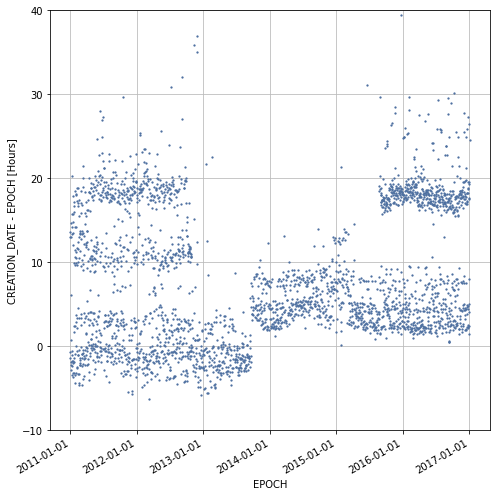

In [13]:
# とりあえず時間差をプロット
fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(df['EPOCH'], df['timelag'], '.', markersize=2.5, markeredgecolor='#5070a0')
#ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.set_xlabel("EPOCH")
ax1.set_ylabel("CREATION_DATE - EPOCH [Hours]")
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
#ax1.set_xlim(datetime(2013, 9, 1), datetime(2013, 10, 1))
ax1.set_ylim(-10, 40)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

パターンが時期によって変わっているように見える。2013/9/18 までと 2013/9/19 以降に分割して調べる。

In [14]:
s = datetime(2013, 9, 19)
df1 = df[df['EPOCH'] < s]
df2 = df[df['EPOCH'] >= s]

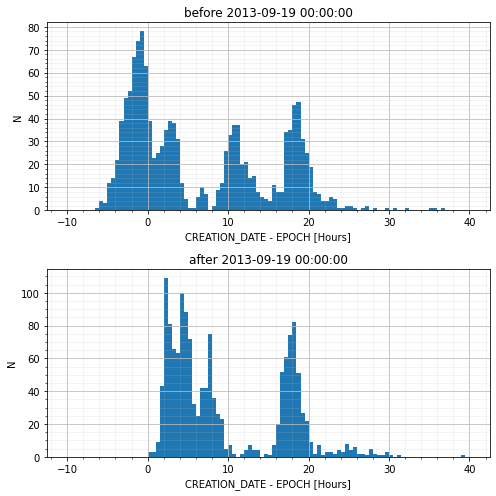

In [15]:
fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(2, 1, 1)
ax1.hist(df1['timelag'], bins=100, range = (-10,40))
ax1.set_title("before {}".format(s))
ax1.set_xlabel("CREATION_DATE - EPOCH [Hours]")
ax1.set_ylabel("N")
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax1.minorticks_on()
ax1.grid(b=True, which='minor', color='#bbbbbb', linestyle='-', alpha=0.2)
ax2 = fig.add_subplot(2, 1, 2)
ax2.hist(df2['timelag'], bins=100, range = (-10,40))
ax2.set_title("after {}".format(s))
ax2.set_xlabel("CREATION_DATE - EPOCH [Hours]")
ax2.set_ylabel("N")
ax2.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax2.minorticks_on()
ax2.grid(b=True, which='minor', color='#bbbbbb', linestyle='-', alpha=0.2)
plt.tight_layout()
plt.show()

時間がないので詳細な解析は後まわし

## 近接しすぎているデータを削除

In [16]:
# EPOCH と CREATION_DATE でソートする (既にされているはずだが念のため)
df = df.sort_values(['EPOCH', 'CREATION_DATE']).reset_index(drop=True)
print(len(df))

2814


In [17]:
# 隣接するデータ間でEPOCH の間隔が1秒以下のデータの個数を確認
dt = -df['EPOCH'].diff(-1) / pd.Timedelta(seconds = 1)
dt2 = df['EPOCH'].diff(1) / pd.Timedelta(seconds = 1)
flag = (dt <= 1) | (dt2 <= 1)
print(flag.sum(), 'records')
#df[['EPOCH', 'CREATION_DATE']][flag].head(15)

22 records


In [18]:
# EPOCH間隔が1秒以上離れているデータごとにグループIDを振る (グループIDはグループの最初のインデックス値)
df['group'] = 0
nlargegroups = 0
currentgroupid = None
first_record_in_group = None
delta = pd.Timedelta(seconds = 1)
for index in df.index:
    if index == 0 or (df.at[index, 'EPOCH'] - df.at[index - 1, 'EPOCH']) > delta:
        currentgroupid = index
        first_record_in_group = True
    else:
        if first_record_in_group:
            first_record_in_group = False
            currentgroupid = index - 1
            nlargegroups += 1

    df.at[index, 'group'] = currentgroupid
print(nlargegroups, 'groups')

11 groups


In [19]:
# 削除するべきデータ数を確認
print(flag.sum() - nlargegroups, 'records will be deleted')

11 records will be deleted


In [20]:
# グループごとにCREATION_DATE が新しいもの1つを残して、他は削除する。
df_out = df.sort_values(['group', 'CREATION_DATE']).drop_duplicates(subset='group', keep='last').sort_values(['EPOCH', 'CREATION_DATE']).drop('group', axis=1)
print(len(df_out), 'records')

2803 records


## 1日間隔のデータを作成

In [21]:
# 出力されるデータのindex
epoch_daily = pd.date_range(date_start, date_end, freq='D')
df_daily = pd.DataFrame(index = epoch_daily)
df_daily.index.name = 'DATE'

In [22]:
# datetime64 をfloat(ユリウス日)に変換
time_in = [x.to_julian_date() for x in df_out['EPOCH']]
time_out = [x.to_julian_date() for x in epoch_daily]

In [23]:
df_daily['SEMIMAJOR_AXIS'] = np.interp(time_out, time_in, df_out['SEMIMAJOR_AXIS'])
df_daily['PERIAPSIS'] = np.interp(time_out, time_in, df_out['PERIAPSIS'])
df_daily['APOAPSIS'] = np.interp(time_out, time_in, df_out['APOAPSIS'])

In [24]:
df_daily['DOT_SEMIMAJOR_AXIS'] = df_daily['SEMIMAJOR_AXIS'].diff()
df_daily['DOT_PERIAPSIS'] = df_daily['PERIAPSIS'].diff()
df_daily['DOT_APOAPSIS'] = df_daily['APOAPSIS'].diff()

In [25]:
df_daily.to_csv('daily.csv')

In [26]:
df_daily.head(5)

,SEMIMAJOR_AXIS,PERIAPSIS,APOAPSIS,DOT_SEMIMAJOR_AXIS,DOT_PERIAPSIS,DOT_APOAPSIS
DATE,,,,,,
2011-01-01,7061.475317,671.695713,694.985287,NaN,NaN,NaN
2011-01-02,7061.472994,671.695380,694.979943,-0.002323,-0.000333,-0.005344
2011-01-03,7061.471702,671.725024,694.948381,-0.001291,0.029644,-0.031562
2011-01-04,7061.471000,671.712776,694.960224,-0.000702,-0.012248,0.011843
2011-01-05,7061.470575,671.746343,694.925382,-0.000425,0.033568,-0.034842


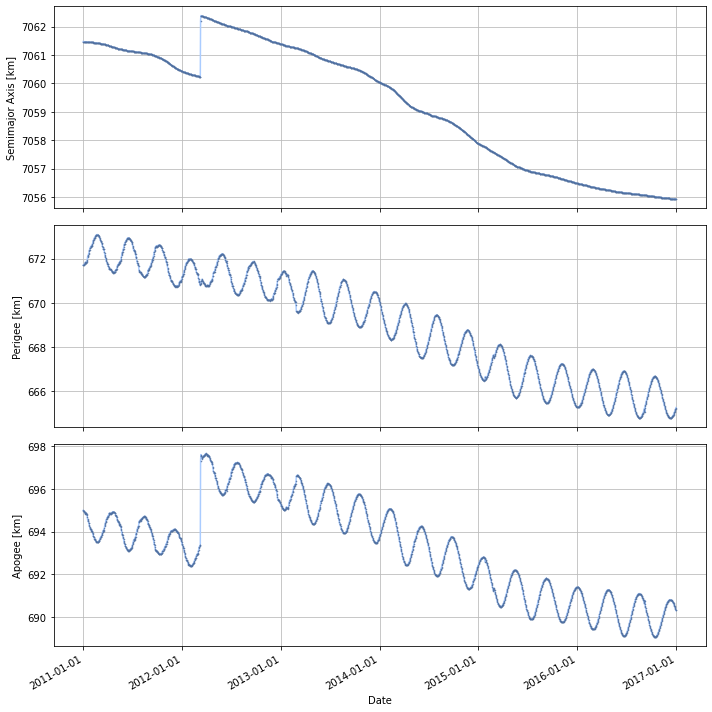

In [27]:
plot4(df_daily, df_daily.index)

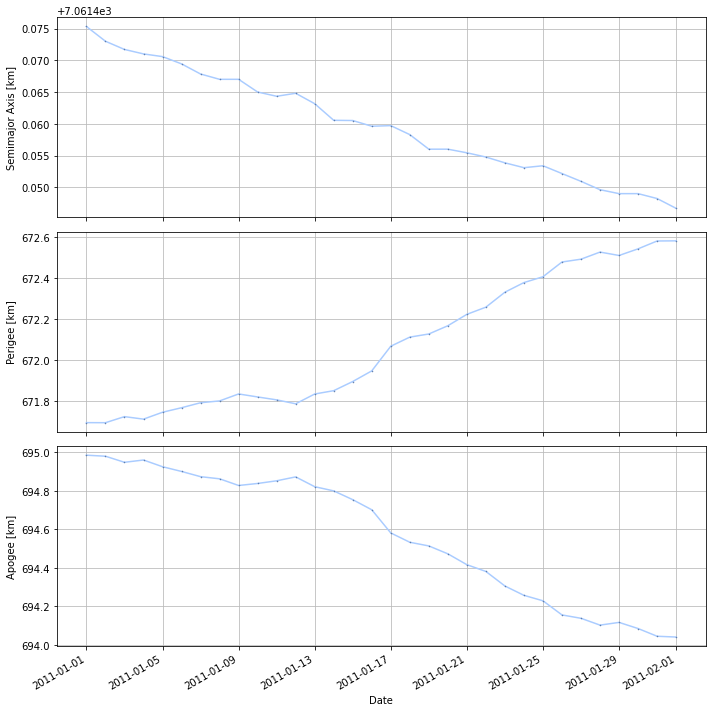

In [28]:
plot4(df_daily['2011-01-01': '2011-02-01'], df_daily['2011-01-01': '2011-02-01'].index)

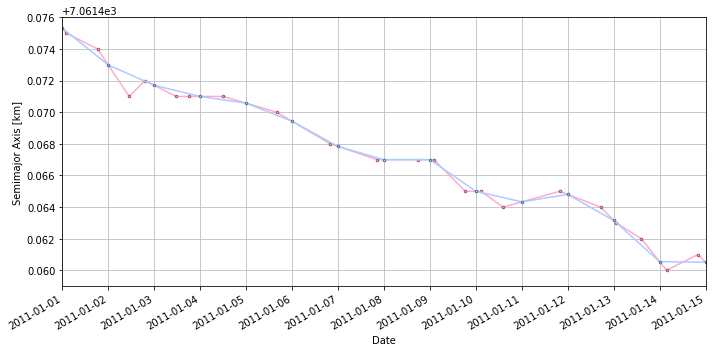

In [29]:
# きちんと補間できている?
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(df_out['EPOCH'], df_out['SEMIMAJOR_AXIS'], color='#ffaacc', marker='.', markersize=5, markeredgecolor='#a05070')
ax1.plot(df_daily.index, df_daily['SEMIMAJOR_AXIS'], color='#aaccff', marker='.', markersize=5, markeredgecolor='#5070a0')
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1, tz=None))
ax1.set_xlabel("Date")
ax1.set_ylabel("Semimajor Axis [km]")
ax1.set_xlim(datetime(2011, 1, 1), datetime(2011, 1, 15))
ax1.set_ylim(7061.459, 7061.476)
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
fig.autofmt_xdate()
plt.tight_layout()    
plt.show()

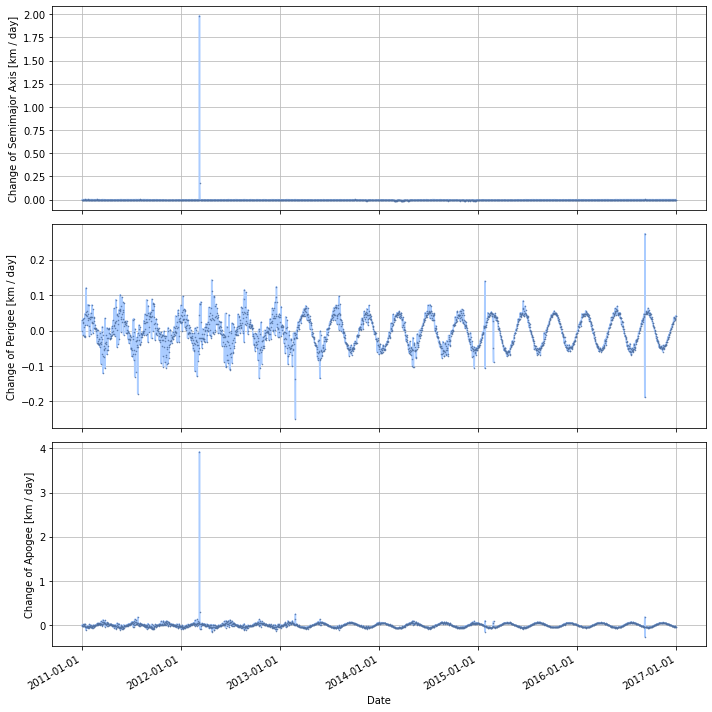

In [30]:
# 軌道長半径、近地点、遠地点の日変化をプロット
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(df_daily['DOT_SEMIMAJOR_AXIS'], color='#aaccff', marker='.', markersize=1, markeredgecolor='#5070a0')
#ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.set_xlabel("Date")
ax1.set_ylabel("Change of Semimajor Axis [km / day]")
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(df_daily['DOT_PERIAPSIS'], color='#aaccff', marker='.', markersize=1, markeredgecolor='#5070a0')
#ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax2.set_xlabel("Date")
ax2.set_ylabel("Change of Perigee [km / day]")
ax2.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(df_daily['DOT_APOAPSIS'], color='#aaccff', marker='.', markersize=1, markeredgecolor='#5070a0')
#ax3.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax3.set_xlabel("Date")
ax3.set_ylabel("Change of Apogee [km / day]")
ax3.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

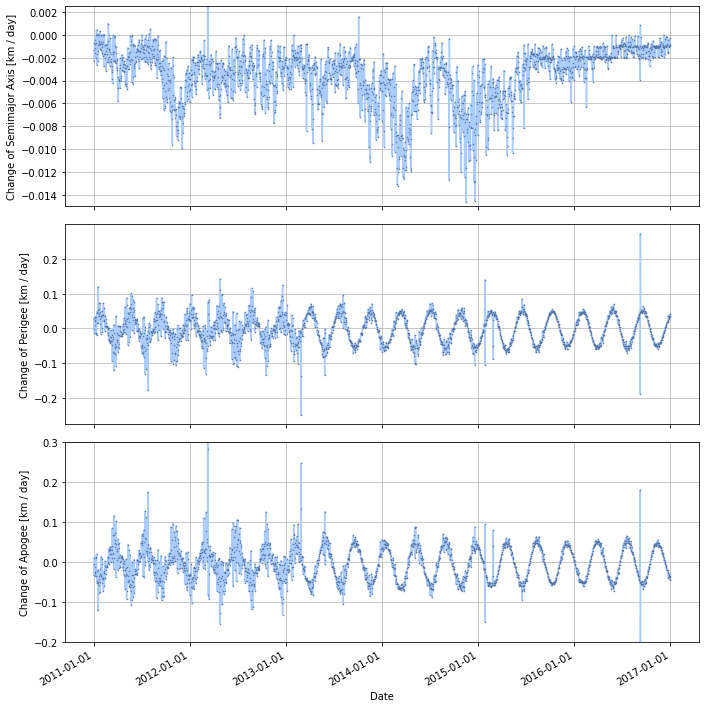

In [31]:
# 軌道長半径、近地点、遠地点の日変化をプロット
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(df_daily['DOT_SEMIMAJOR_AXIS'], color='#aaccff', marker='.', markersize=1, markeredgecolor='#5070a0')
#ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.set_xlabel("Date")
ax1.set_ylabel("Change of Semimajor Axis [km / day]")
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax1.set_ylim(-0.015,0.0025)
ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(df_daily['DOT_PERIAPSIS'], color='#aaccff', marker='.', markersize=1, markeredgecolor='#5070a0')
#ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax2.set_xlabel("Date")
ax2.set_ylabel("Change of Perigee [km / day]")
ax2.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(df_daily['DOT_APOAPSIS'], color='#aaccff', marker='.', markersize=1, markeredgecolor='#5070a0')
#ax3.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax3.set_xlabel("Date")
ax3.set_ylabel("Change of Apogee [km / day]")
ax3.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax3.set_ylim(-0.2,0.3)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()